## Protocol

In [1]:
from pyannote.core import notebook, Segment
notebook.reset()
from pyannote.database import registry
registry.load_database("AMI-diarization-setup/pyannote/database.yml")
from pyannote.database import FileFinder
protocol = registry.get_protocol('AMI.SpeakerDiarization.only_words', 
                                 preprocessors={"audio": FileFinder()})

'AMI.SpeakerDiarization.only_words' found in /home/brahou/pyannote-audio/tutorials/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.word_and_vocalsounds' found in /home/brahou/pyannote-audio/tutorials/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.


## Training

In [2]:
from pyannote.audio.tasks import SpeakerDiarization
diarization_task = SpeakerDiarization(protocol, duration=5, batch_size=256, max_speakers_per_frame = 2,
                                      max_speakers_per_chunk = 3, num_workers = 0)

from pyannote.audio.models.segmentation import PyanNet
model = PyanNet(task=diarization_task, lstm = {
        "hidden_size": 128,
        "num_layers": 2,
        "bidirectional": True,
        "monolithic": True,
        "dropout": 0.0,
    })
#If you infer without training
model.setup(stage = 'fit')



/home/brahou/pyannote-audio/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
/home/brahou/anaconda3/lib/python3.11/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


Protocol AMI.SpeakerDiarization.only_words does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


In [61]:
#batches = iter(model.train_dataloader())

In [62]:
#%timeit next(batches)

In [63]:
#import pytorch_lightning as pl
#trainer = pl.Trainer(max_epochs=1,accelerator='gpu', devices=[0])
#trainer.fit(model)

In [13]:
from pyannote.audio import Model
pretrained_model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True)

In [15]:
#import torch
#model.load_state_dict(torch.load('model.pt'), strict = False)


## Testing

In [16]:
from pyannote.audio import Inference
from pyannote.audio.torchmetrics import DiarizationErrorRate
import numpy as np
import torch
from rich.progress import Progress


def test_torchmetrics(model, files, latency):
    with Progress() as progress:
        main_task = progress.add_task(protocol.name, total=len(files))
        file_task = progress.add_task("Processing", total=1.0)
    
        def progress_hook(completed: int = None, total: int = None):
            progress.update(file_task, completed=completed / total)   

        inference = Inference(model)
        metric = DiarizationErrorRate()
        num_frames = model.example_output.num_frames
        delay = int(np.floor(latency / model.example_output.frames.duration)) # round down
        print(f"delay : {delay:d} frame(s)")

        # initialize error list
        error=[]
        for file in files:
            progress.update(file_task, description=file["uri"])
            # calculate inference for current file
            window_inference = inference(file)
            hypothesis = torch.from_numpy(window_inference.data)

            # discretize reference annotation
            annotation = file["annotation"]
            sliding_window = window_inference.sliding_window
            support = Segment(sliding_window[0].start, sliding_window[hypothesis.size(0) - 1].end)
            resolution = sliding_window.duration / num_frames
            discretization = annotation.discretize(support, resolution=resolution)
            max_num_speaker = len(annotation.labels())
            reference = torch.zeros((hypothesis.size(0),hypothesis.size(1),max_num_speaker))
            for i in range(hypothesis.size(0)):
                reference_window = discretization.crop(sliding_window[i], mode="center")
                reference[i] = torch.from_numpy(np.array(reference_window.data))[:num_frames]

            # pad the hypothesis and permute the inputs (torchmetrics takes (num_chunks,num_speakers,num_frames))
            if reference.size(2) > hypothesis.size(2):
                hypothesis = torch.nn.functional.pad(hypothesis, (0, 1, 0, 0, 0, 0))
            hypothesis = hypothesis.permute(0,2,1)
            reference = reference.permute(0,2,1)
            print(f"hypothesis of size : {hypothesis[:,:,delay:].size()}")
            print(f"reference of size : {reference[:,:,:num_frames-delay].size()}")

            error.append(metric(hypothesis[:,:,delay:], reference[:,:,:num_frames-delay]))
            print(f"current error list : {error}")
            progress.advance(main_task)
        return np.array(error).mean()


In [17]:
from pyannote.audio import Inference
from pyannote.audio.torchmetrics import DiarizationErrorRate
import numpy as np
import torch
from rich.progress import Progress

def test_torchmetrics_per_frame(model, files, latency):
    
    inference = Inference(model)
    metric = DiarizationErrorRate(per_frame = True)
    num_frames = model.example_output.num_frames
    delay = int(np.floor(latency / model.example_output.frames.duration)) # round down
    print(f"delay : {delay:d} frame(s)")
    
    # initialize error lists
    error=[]
    false_alarm_error=[]
    missed_detection_error=[]
    speaker_confusion_error=[]
    
    for file in files:
        # calculate inference for current file
        window_inference = inference(file)
        hypothesis = torch.from_numpy(window_inference.data)
        
        # discretize reference annotation
        annotation = file["annotation"]
        sliding_window = window_inference.sliding_window
        support = Segment(sliding_window[0].start, sliding_window[hypothesis.size(0) - 1].end)
        resolution = sliding_window.duration / num_frames
        discretization = annotation.discretize(support, resolution=resolution)
        max_num_speaker = len(annotation.labels())
        reference = torch.zeros((hypothesis.size(0),hypothesis.size(1),max_num_speaker))
        for i in range(hypothesis.size(0)):
            reference_window = discretization.crop(sliding_window[i], mode="center")
            reference[i] = torch.from_numpy(np.array(reference_window.data))[:num_frames]
            
        # permute the inputs (torchmetrics takes (num_chunks,num_speakers,num_frames))
        hypothesis = torch.nn.functional.pad(hypothesis, (0, 1, 0, 0, 0, 0))
        hypothesis = hypothesis.permute(0,2,1)
        reference = reference.permute(0,2,1)
        print(f"hypothesis of size : {hypothesis[:,:,delay:].size()}")
        print(f"reference of size : {reference[:,:,:num_frames-delay].size()}")
        
        # calculate the metrics
        false_alarm, missed_detection, speaker_confusion, total_speech = metric(
            hypothesis[:,:,delay:], reference[:,:,:num_frames-delay])
        print(f"DER for this file = {(false_alarm.sum() + missed_detection.sum() + speaker_confusion.sum()) / (total_speech + 1e-8)}")
        false_alarm_per_frame = false_alarm * num_frames / (total_speech + 1e-8)
        missed_detection_per_frame = missed_detection * num_frames / (total_speech + 1e-8)
        speaker_confusion_per_frame = speaker_confusion * num_frames / (total_speech + 1e-8)
        der_per_frame = false_alarm_per_frame + missed_detection_per_frame + speaker_confusion_per_frame
        
        # append the list of errors with current file errors
        error.append(np.array(der_per_frame))
        false_alarm_error.append(np.array(false_alarm_per_frame))
        missed_detection_error.append(np.array(missed_detection_per_frame))
        speaker_confusion_error.append(np.array(speaker_confusion_per_frame))
        
    # calculate mean of all test files     
    error=np.array(error).mean(axis = 0)
    false_alarm_error = np.array(false_alarm_error).mean(axis = 0)
    missed_detection_error = np.array(missed_detection_error).mean(axis = 0)
    speaker_confusion_error = np.array(speaker_confusion_error).mean(axis = 0)
    
    return error, false_alarm_error, missed_detection_error, speaker_confusion_error

In [7]:
files = list(getattr(protocol, "test")())
latency = 0
der = test_torchmetrics(model, files, latency)
print(f"Local DER = {abs(der) * 100:.1f}%")

Output()

delay : 0 frame(s)

hypothesis of size : torch.Size([1669, 4, 293])

reference of size : torch.Size([1669, 4, 293])

current error list : [tensor(0.2593)]

Local DER = 25.9%


In [18]:
files = list(getattr(protocol, "test")())
latency = 0
error_per_frame, false_alarm, missed_detection, speaker_confusion = test_torchmetrics_per_frame(model, files, latency)
error_per_frame

delay : 0 frame(s)
hypothesis of size : torch.Size([1669, 4, 293])
reference of size : torch.Size([1669, 4, 293])
DER for this file = 0.25927138328552246
hypothesis of size : torch.Size([4096, 4, 293])
reference of size : torch.Size([4096, 4, 293])
DER for this file = 0.15371479094028473
hypothesis of size : torch.Size([3633, 4, 293])
reference of size : torch.Size([3633, 4, 293])
DER for this file = 0.14838285744190216
hypothesis of size : torch.Size([3880, 4, 293])
reference of size : torch.Size([3880, 4, 293])
DER for this file = 0.24103473126888275
hypothesis of size : torch.Size([2090, 4, 293])
reference of size : torch.Size([2090, 4, 293])
DER for this file = 0.26910367608070374
hypothesis of size : torch.Size([4682, 4, 293])
reference of size : torch.Size([4682, 4, 293])
DER for this file = 0.19512279331684113
hypothesis of size : torch.Size([4660, 4, 293])
reference of size : torch.Size([4660, 4, 293])
DER for this file = 0.196478009223938
hypothesis of size : torch.Size([4436,

array([0.33141226, 0.32828283, 0.3254712 , 0.32385397, 0.32102078,
       0.31781587, 0.31483144, 0.3118828 , 0.3095508 , 0.30769417,
       0.30492172, 0.30279967, 0.30185664, 0.3003403 , 0.29950818,
       0.2974546 , 0.29643768, 0.2952635 , 0.2943591 , 0.2934955 ,
       0.29226917, 0.29182842, 0.28979072, 0.28865463, 0.28763038,
       0.28585577, 0.2846649 , 0.2832142 , 0.28189656, 0.28114805,
       0.27901095, 0.27710798, 0.27613223, 0.27480465, 0.2739618 ,
       0.27200747, 0.2700129 , 0.26821354, 0.26670614, 0.2651845 ,
       0.2638062 , 0.26239705, 0.26102602, 0.25953332, 0.2591208 ,
       0.25828105, 0.2570774 , 0.2559183 , 0.25584063, 0.25441644,
       0.25364774, 0.2519333 , 0.2509564 , 0.25014085, 0.24833299,
       0.24697796, 0.24619237, 0.24567632, 0.24573608, 0.24532034,
       0.24451478, 0.24479821, 0.24377097, 0.24390468, 0.24280521,
       0.2421332 , 0.24140316, 0.24052833, 0.23971869, 0.23828493,
       0.23733024, 0.23671696, 0.23572822, 0.23477092, 0.23483

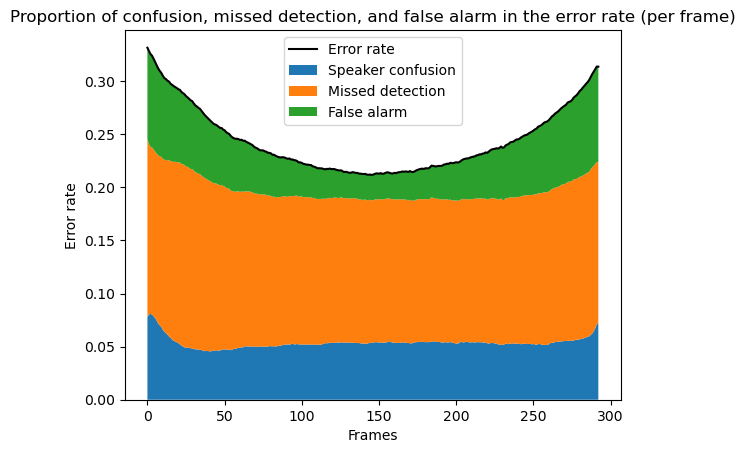

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

frames = np.arange(error_per_frame.shape[0]) 

# Plot the stacked area plot
ax.plot(frames, error_per_frame, color="black", label="Error rate")

ax.stackplot(frames, false_alarm, missed_detection, speaker_confusion, 
             labels=["Speaker confusion", "Missed detection", "False alarm"])

# Set axis labels and a title
ax.set_xlabel("Frames")
ax.set_ylabel("Error rate")
ax.set_title("Proportion of confusion, missed detection, and false alarm in the error rate (per frame)")
ax.legend(loc='upper center')

plt.show()

## Pipeline

In [ ]:
model.setup(stage = 'fit')
from pyannote.audio.pipelines import SpeakerDiarization
pipeline = SpeakerDiarization(model).instantiate({
    "segmentation": {
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 2,
        "threshold": 0.01,
    },
})
files = list(getattr(protocol, "test")())

from pyannote.audio.utils.preview import listen
listen("test_short.wav")

In [ ]:
#from huggingface_hub import notebook_login
#notebook_login()

In [ ]:
from pyannote.audio import Pipeline
pretrained_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=True)

In [ ]:
annotation = pipeline("test_short.wav")


In [ ]:
list(annotation.itertracks())

## Optimizing pipeline hyper-parameters

W can try to optimize the hyper-parameters (that we chose manually above) on the validation set to get better performance.

In [ ]:
# to make things faster, we run the inference once and for all... 
validation_files = list(protocol.development())
for file in validation_files:
    file['osd'] = inference(file)
# ... and tell the pipeline to load OSD scores directly from files
pipeline = OverlappedSpeechDetectionPipeline(scores="osd")

In [ ]:
from pyannote.pipeline import Optimizer
optimizer = Optimizer(pipeline)
optimizer.tune(validation_files, n_iterations=200, show_progress=False)

There you go: better hyper-parameters that should lead to better results!

In [ ]:
optimized_pipeline = OverlappedSpeechDetectionPipeline(scores=inference).instantiate(optimizer.best_params)
optimized_pipeline(test_file).get_timeline()

In [ ]:
from pyannote.audio import Inference
from pyannote.audio.utils.metric import DiscreteDiarizationErrorRate
from pyannote.audio.utils.signal import binarize
from rich.progress import Progress

#model.setup(stage = 'fit')

def test_discrete(model, files): 
    inference = Inference(model)
    metric = DiscreteDiarizationErrorRate()
    for file in files[0:1]:
        reference = file["annotation"]
        hypothesis = binarize(inference(file))
        uem = file["annotated"]
        _ = metric(reference, hypothesis, uem=uem)
    return metric
        
files = list(getattr(protocol, "train")())
print(f"Local DER = {abs(test_discrete(model, files)) * 100:.1f}%")